# Mini-Lab: Logistic Regression and SVMs

You are to perform predictive analysis (classification) upon a data set:
model the dataset using methods we have discussed in class: 
logistic regression and support vector machines, and making conclusions from the analysis.
Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). 
This report is worth 10% of the final grade. 
You may complete this assignment in teams of as many as three people. 
Write a report covering all the steps of the project. 
The format of the document can be PDF, *.ipynb, or HTML. 

You can write the report in whatever format you like, but it is easiest to turn in the rendered iPython notebook.
The results should be reproducible using your report.

Please carefully describe every assumption and every step in your report.

Total Points 	100	
		
Create Models	50

    Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

Model Advantages	10	

       Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Interpret Feature Importance	30

       Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

Interpret Support Vectors	10	

    Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

## SVM and Logistic Regression Modeling

### Load the Data

In [1]:
# Data Processing
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy import stats

# Data Visualization
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

# Code comparison
import time

# import dataset
df = pd.read_csv("cleanedAdultCensus.csv")

In [2]:
df.head()

,age,workclass,fnlwgt,education,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income,education_,jobtype
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K,HS,other
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,HS,private
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K,college,other
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,preHS,private
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,college,private


### Data Formatting

In [3]:
# I am dropping these because we have made other columns that capture the same information
df=df.drop(columns=['education', 'educationNum', 'workclass']) 
df.head()

,age,fnlwgt,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income,education_,jobtype
0,90,77053,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K,HS,other
1,82,132870,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,HS,private
2,66,186061,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K,college,other
3,54,140359,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,preHS,private
4,41,264663,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,college,private


In [4]:
#adapted from https://stackoverflow.com/questions/23307301/replacing-column-values-in-a-pandas-dataframe
df.occupation.replace(['?'], ['occupation_other'], inplace=True)
df.nativeCountry.replace(['?'], ['native_country_other'], inplace=True)
df.income.replace(['<=50K'], [0], inplace=True)
df.income.replace(['>50K'], [1], inplace=True)
df.head()

,age,fnlwgt,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income,education_,jobtype
0,90,77053,Widowed,occupation_other,Not-in-family,White,Female,0,4356,40,United-States,0,HS,other
1,82,132870,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,HS,private
2,66,186061,Widowed,occupation_other,Unmarried,Black,Female,0,4356,40,United-States,0,college,other
3,54,140359,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,preHS,private
4,41,264663,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,college,private


In [5]:
maybe_na = ["?"]
df.isin(maybe_na).sum()

age              0
fnlwgt           0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursPerWeek     0
nativeCountry    0
income           0
education_       0
jobtype          0
dtype: int64

In [6]:
 categorical_columns=['maritalStatus', 'occupation', 'relationship', 'race', 'sex', 'nativeCountry', 'education_', 'jobtype']

In [7]:
for name in categorical_columns:
    
    #adapted from https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df[name])
    # Drop column B as it is now encoded
    df = df.drop(name, axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    
df.head()  

,age,fnlwgt,capitalGain,capitalLoss,hoursPerWeek,income,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,...,Yugoslavia,native_country_other,HS,college,postGrad,preHS,entrepreneur,government,other,private
0,90,77053,0,4356,40,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,82,132870,0,4356,18,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,66,186061,0,4356,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,54,140359,0,3900,40,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,41,264663,0,3900,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [8]:
#list(df) # this prints all the features in the dataset

In [9]:
X= df.drop(columns=['income'])
y= df['income']

In [10]:
X.head()

,age,fnlwgt,capitalGain,capitalLoss,hoursPerWeek,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,...,Yugoslavia,native_country_other,HS,college,postGrad,preHS,entrepreneur,government,other,private
0,90,77053,0,4356,40,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,82,132870,0,4356,18,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,66,186061,0,4356,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,54,140359,0,3900,40,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,41,264663,0,3900,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [11]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

## Logistic Regression

# 50 points. Create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  Assess how well each model performs (use 80/20 training/testing split for your data).  Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.

### Assumptions

#### Assumption 1

"First, binary logistic regression requires the dependent variable to be binary and ordinal logistic regression requires the dependent variable to be ordinal." [stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

     The dependent variable is binary. 

#### Assumption 2
"Second, logistic regression requires the observations to be independent of each other.  In other words, the observations should not come from repeated measurements or matched data."  [stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

    There may be some lack of independence in the data because we may have multiple observations from the same household or same town. We can assume geographic relation may have some degree of statistical dependence. However, since there is nothing to do about this with our present tool kit we will just have to be aware of some bias in the data. 

#### Assumption 3

"Third, logistic regression requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other."
[stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

#### Variables with the highest correlation

In [12]:
# Code adapted from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr = X.corr()
c = corr.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
print(so[7960:8008:2])
high_corr = so[7960:8008:2]

private             other                   0.373022
college             preHS                   0.373359
Own-child           Married-civ-spouse      0.380070
United-States       native_country_other    0.396016
Asian-Pac-Islander  Philippines             0.408355
Mexico              United-States           0.416286
Male                Married-civ-spouse      0.431805
Married-civ-spouse  Male                    0.431805
age                 Own-child               0.432918
Asian-Pac-Islander  White                   0.439572
Not-in-family       Husband                 0.482936
Never-married       Own-child               0.509226
age                 Never-married           0.534359
Married-civ-spouse  Not-in-family           0.537588
private             entrepreneur            0.539523
Husband             Never-married           0.576730
Male                Husband                 0.580135
Female              Husband                 0.580135
government          private                 0.

#### Getting unique variable names for highest correlation

In [13]:
all_high_corr_labels = []

#print(high_corr.index.tolist())
labels = high_corr.index.tolist()
for tuple_ in labels:
    all_high_corr_labels.append(tuple_[0])
    all_high_corr_labels.append(tuple_[1])

unique_high_corr_labels = list(set(all_high_corr_labels))
print(unique_high_corr_labels)

['native_country_other', 'college', 'Not-in-family', 'HS', 'United-States', 'private', 'Female', 'Philippines', 'Married-civ-spouse', 'age', 'Asian-Pac-Islander', 'other', 'occupation_other', 'government', 'Male', 'Mexico', 'Own-child', 'Husband', 'Never-married', 'preHS', 'White', 'entrepreneur', 'Black']


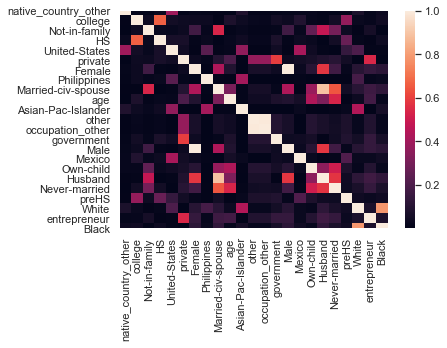

In [14]:
high_corr_map = abs(X[unique_high_corr_labels].corr())

sns.heatmap(high_corr_map, 
        xticklabels=high_corr_map.columns,
        yticklabels=high_corr_map.columns)

#### Variables with high income correlation

In [15]:
corr_features_to_check = unique_high_corr_labels.copy()
corr_features_to_check.append('income')
#print(corr_features_to_check)
high_correlation_suspects = df[corr_features_to_check]
all_corr_with_income = high_correlation_suspects.corr()
corr_with_income = abs(all_corr_with_income['income']).sort_values(kind="quicksort")
print(corr_with_income[15:24])

Not-in-family         0.188497
Female                0.215980
Male                  0.215980
Own-child             0.228532
age                   0.234037
Never-married         0.318440
Husband               0.401035
Married-civ-spouse    0.444696
income                1.000000
Name: income, dtype: float64


#### Removing variables with high correlation and low relative correlation with income

    Here the variables with high correlation are being removed. If there is a choice between two 
    variables to remove, the variable with the lower correlation with income is being taken out.  

In [16]:
#print(corr_with_income[15:24])
print(corr_with_income)
print()
print(high_corr)
print()
#print(unique_high_corr_labels)

native_country_other    0.003038
Asian-Pac-Islander      0.010543
Philippines             0.012306
United-States           0.034470
government              0.061903
Mexico                  0.062901
private                 0.078528
occupation_other        0.078583
other                   0.079348
White                   0.085224
Black                   0.089089
entrepreneur            0.105861
college                 0.126975
HS                      0.131189
preHS                   0.166292
Not-in-family           0.188497
Female                  0.215980
Male                    0.215980
Own-child               0.228532
age                     0.234037
Never-married           0.318440
Husband                 0.401035
Married-civ-spouse      0.444696
income                  1.000000
Name: income, dtype: float64

private             other                   0.373022
college             preHS                   0.373359
Own-child           Married-civ-spouse      0.380070
United-States      

#### Variables to drop in decreasing order of importance 

    Husband, other, White, college, never-married, 
    government, Female, private, not-in-family, 
    age, United-States, Asian-Pac-Islander, native_country_other,  

#### Rechecking Correlations

In [17]:
# Code adapted from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

'occupation_other',  'Mexico', 'Married-civ-spouse', 
'entrepreneur', 'HS',  'other', 
'Black', 'Male', 'Philippines', 
'preHS', 'Own-child', 

X = X.drop(columns = ['Husband', 'other', 'White', 'college', 'Never-married',
'government', 'Female', 'private', 'Not-in-family', 
'age', 'United-States', 'Asian-Pac-Islander', 'native_country_other'])

corr = X.corr()
c = corr.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
print("Correlation between variables \n")
print(so[5820:5852:2])
print(X.shape)

Correlation between variables 

Prof-specialty      HS                    0.217372
Craft-repair        Male                  0.223128
Male                Divorced              0.228621
                    hoursPerWeek          0.229309
Married-civ-spouse  Wife                  0.240279
hoursPerWeek        Own-child             0.249254
Adm-clerical        Male                  0.263148
HS                  preHS                 0.267427
Married-civ-spouse  Unmarried             0.317487
Male                Wife                  0.319311
                    Unmarried             0.321273
Divorced            Unmarried             0.328876
postGrad            Prof-specialty        0.332672
Married-civ-spouse  Divorced              0.366837
Own-child           Married-civ-spouse    0.380070
Married-civ-spouse  Male                  0.431805
dtype: float64
(32561, 77)


#### Discussion of Multicollinearity Assumption

As we can see directly above the majority of the multicollinearity has been removed. This is sufficient to run a logistic regression model. [motivation](https://stats.stackexchange.com/questions/87749/when-correlation-turns-too-high)

#### Assumption 4

"Fourth, logistic regression assumes linearity of independent variables and log odds.  although this analysis does not require the dependent and independent variables to be related linearly, it requires that the independent variables are linearly related to the log odds."
[stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

    Most of our variables are categorical and cannot be checked for linearity.[1] The continuous variables in our study are age, fnlwgt, capitalGain, captialLoss, and hoursPerWeek. We want to see a straight line or an S-shape.[2][3] All of our continuous variables as shown below meet this standard. 
    
sources: [1](https://www.statalist.org/forums/forum/general-stata-discussion/general/1441699-linearity-to-logit-assumption-logistic-regression), [2](http://www.sthda.com/english/articles/36-classification-methods-essentials/148-logistic-regression-assumptions-and-diagnostics-in-r/), [3](https://pythonfordatascience.org/logistic-regression-python/)

Text(0.5, 1.0, 'Age Log Odds Linear Plot')

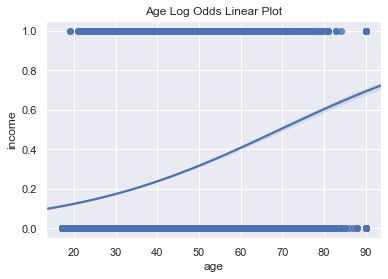

In [18]:
# code adapted from https://pythonfordatascience.org/logistic-regression-python/
sns.regplot(x= 'age', y= 'income', data= df, logistic= True).set_title("Age Log Odds Linear Plot")

Text(0.5, 1.0, 'fnlwgt Log Odds Linear Plot')

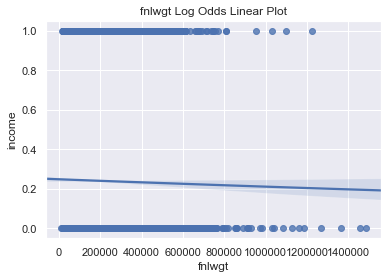

In [19]:
sns.regplot(x= 'fnlwgt', y= 'income', data= df, logistic= True).set_title("fnlwgt Log Odds Linear Plot")

Text(0.5, 1.0, 'capitalGain Log Odds Linear Plot')

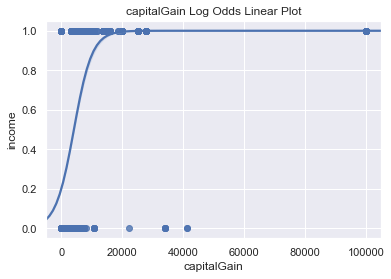

In [20]:
sns.regplot(x= 'capitalGain', y= 'income', data= df, logistic= True).set_title("capitalGain Log Odds Linear Plot")

Text(0.5, 1.0, 'capitalLoss Log Odds Linear Plot')

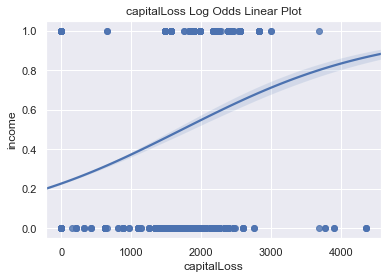

In [21]:
sns.regplot(x= 'capitalLoss', y= 'income', data= df, logistic= True).set_title("capitalLoss Log Odds Linear Plot")

Text(0.5, 1.0, 'hoursPerWeek Log Odds Linear Plot')

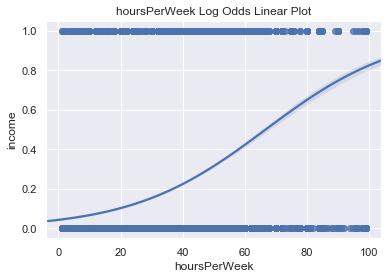

In [22]:
sns.regplot(x= 'hoursPerWeek', y= 'income', data= df, logistic= True).set_title("hoursPerWeek Log Odds Linear Plot")

#### Assumption 5

"Finally, logistic regression typically requires a large sample size. A general guideline is that you need at minimum of 10 cases with the least frequent outcome for each independent variable in your model. For example, if you have 5 independent variables and the expected probability of your least frequent outcome is .10, then you would need a minimum sample size of 500 (10*5 / .10)."
[stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

In [23]:
def minimum_number_of_samples(number_of_classes, probability_of_least_frequent_outcome):
    min_sample_count = (10*number_of_classes)/probability_of_least_frequent_outcome
    return min_sample_count

In [24]:
dataset_length = y.shape[0]
probability_of_least_frequent_outcome = np.sum(y)/dataset_length
number_of_classes = 2

minimum_samples = minimum_number_of_samples(number_of_classes, probability_of_least_frequent_outcome)

print("The the minimum number of samples we need is %d." %(minimum_samples))
print("Dataset length   %d" %(dataset_length))

The the minimum number of samples we need is 83.
Dataset length   32561


As we can see the maximum number of samples we need to run this analysis is 83. The number of samples in our dataset is 32561. So we have more than enough sample in order to run logistic regression.

#### What is the minimum number of observations in a feature before we have to scrap it?

In [25]:
#occurances = df.sum(axis=0)
#occurances = occurances.sort_values()
#print(occurances[40:50])

#labels_for_small_columns = occurances[occurances <= 900].index
#df = df.drop(columns = labels_for_small_columns)

#### Do we have any influential values? Is it important to check for them with moderm logistic regression algorithms?

In [26]:
# Code adapted from https://www.statsmodels.org/dev/generated/statsmodels.graphics.regressionplots.influence_plot.html
 
    #put code here

In [31]:
for i, item in enumerate(list(X)):
    print(i+1, item)
#X.shape

1 fnlwgt
2 capitalGain
3 capitalLoss
4 hoursPerWeek
5 Divorced
6 Married-AF-spouse
7 Married-civ-spouse
8 Married-spouse-absent
9 Separated
10 Widowed
11 Adm-clerical
12 Armed-Forces
13 Craft-repair
14 Exec-managerial
15 Farming-fishing
16 Handlers-cleaners
17 Machine-op-inspct
18 Other-service
19 Priv-house-serv
20 Prof-specialty
21 Protective-serv
22 Sales
23 Tech-support
24 Transport-moving
25 occupation_other
26 Other-relative
27 Own-child
28 Unmarried
29 Wife
30 Amer-Indian-Eskimo
31 Black
32 Other
33 Male
34 Cambodia
35 Canada
36 China
37 Columbia
38 Cuba
39 Dominican-Republic
40 Ecuador
41 El-Salvador
42 England
43 France
44 Germany
45 Greece
46 Guatemala
47 Haiti
48 Holand-Netherlands
49 Honduras
50 Hong
51 Hungary
52 India
53 Iran
54 Ireland
55 Italy
56 Jamaica
57 Japan
58 Laos
59 Mexico
60 Nicaragua
61 Outlying-US(Guam-USVI-etc)
62 Peru
63 Philippines
64 Poland
65 Portugal
66 Puerto-Rico
67 Scotland
68 South
69 Taiwan
70 Thailand
71 Trinadad&Tobago
72 Vietnam
73 Yugoslavia
74

#### Dividing Data into Test-Train Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
X_train.head()

,fnlwgt,capitalGain,capitalLoss,hoursPerWeek,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Separated,Widowed,...,South,Taiwan,Thailand,Trinadad&Tobago,Vietnam,Yugoslavia,HS,postGrad,preHS,entrepreneur
27585,160623,0,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18010,92649,0,0,40,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
22472,72743,0,0,50,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4585,118500,0,0,40,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11191,189802,0,0,40,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
y_train.head()

27585    0
18010    1
22472    0
4585     0
11191    0
Name: income, dtype: int64

### Logistic Regression Model

In [38]:
#adapted from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#LR = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0,
# fit_intercept=True, intercept_scaling=1, class_weight=None,
# random_state=None, solver='lbfgs', max_iter=100, multi_class='auto',
# verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

start_time = time.time()
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("Training Accuracy: ", clf.score(X_train, y_train))
print("Testing Accuracy: ", clf.score(X_test, y_test))
print("\n--- Logistic Regression Model Run and Test time: %s seconds ---" % (time.time() - start_time))


weights = clf.coef_[0]
# print("Model weights: ", weights)
# print(type(weights))
# print(weights.items())

parameters = clf.get_params()

#print(type(parameters))
#print(parameters.items())


Training Accuracy:  0.7972495988998396
Testing Accuracy:  0.7971338172343198

--- Logistic Regression Model Run and Test time: 0.16803693771362305 seconds ---


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Checking Features 

In [32]:
# code adapted from https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values
import statsmodels.api as sm
logit_model=sm.Logit(y_train.values,X_train.values)
result=logit_model.fit()
print(result.summary())

         Current function value: 0.325899
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                21815
Model:                          Logit   Df Residuals:                    21738
Method:                           MLE   Df Model:                           76
Date:                Fri, 07 Feb 2020   Pseudo R-squ.:                  0.4091
Time:                        15:49:05   Log-Likelihood:                -7109.5
converged:                      False   LL-Null:                       -12033.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.566e-07   2.03e-07      3.723      0.000    3.58e-07    1.15e-06
x2             0.0003   1.22e-05     25.201      0.000       0.00

/Users/kaileyayala/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### candidates for removal 
**objective**: either manually remove those with high p-values or use feature selection tools to do it and then recheck to make sure they are all approximately significant. 

## SVM Section

In [33]:
# svm stuff goes here

kernel string, optional (default=’rbf’)

    Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).


In [34]:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

import numpy as np
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X, y)
print(clf.predict([[-0.8, -1]]))


[1]


# 10 points: Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy?  In terms of training time or efficiency?  Explain in detail.

In [35]:
# adeapted from https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution

start_time = time.time()
2*2
print("--- %s seconds ---" % (time.time() - start_time))

# implement cross validation

--- 0.00010275840759277344 seconds ---


# 30 points. Interpret Feature Importance

Remember that the general equation for logistic regression is:

\begin{align}
log(p/(1-p)) = \beta_{0} + \beta_{1} * x_{1} + \beta_{2} * x_{2} + ... + \beta_{k} * x_{k}
\end{align}`

Each coefficient from the logistic regression is an indicator of how strongly the associated parameter is correlated with the logged odds ratio of the dependent variable - in this case, the odds a person makes over \$50k. 

The regression model from the sklearn package first normalizes all our variables into a uniform scale before regressing. Accordingly, we chose to not include an intercept term in our model given all our transformed numeric variables should have mean 0. 

In [60]:
# calculate p values: sklearn doesn't have a way to do this manually
# Code taken from rspeare, https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
class modified_logreg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self, linear_model):#,**kwargs):
        self.model = linear_model

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stats.stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [69]:
wrapped_model = modified_logreg(clf)
wrapped_model.fit(X_train, y_train)
detailed_scores = {'Feature' : X_train.columns, 'coefficient' : weights, 'z_score' : wrapped_model.z_scores, 'p_values' : wrapped_model.p_values, 'sigma' : wrapped_model.sigma_estimates}
detailed_scores = pd.DataFrame(detailed_scores)
pd.set_option('display.max_rows', None)
detailed_scores

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Feature,coefficient,z_score,p_values,sigma
0,fnlwgt,-3.723875e-06,-2.023305e+01,5.010267e-91,1.840491e-07
1,capitalGain,3.277125e-04,3.085634e+01,4.605416e-209,1.062059e-05
2,capitalLoss,7.741590e-04,2.162925e+01,9.531523e-104,3.579222e-05
3,hoursPerWeek,-1.497369e-02,-1.008012e+01,6.764364e-24,1.485468e-03
4,Divorced,-4.460941e-04,-7.612464e-03,9.939262e-01,5.860049e-02
5,Married-AF-spouse,2.966808e-06,4.790588e-06,9.999962e-01,6.192994e-01
6,Married-civ-spouse,1.139852e-03,2.226878e-02,9.822335e-01,5.118611e-02
7,Married-spouse-absent,-4.420318e-05,-3.002339e-04,9.997604e-01,1.472291e-01
8,Separated,-1.059514e-04,-1.031785e-03,9.991768e-01,1.026874e-01
9,Widowed,-1.193443e-04,-1.171212e-03,9.990655e-01,1.018982e-01


Looking at the regression weights, we see that the most strongly predictive features of an individual's income are his/her number of hours worked per week, marital status, and educational attainment. Looking at his/her hours worked per week for example, we see that an 50\% increase in an individual's working hours results in a 0.015\* 50 = .75\% decrease in his or her's log odds of making over \$50k, holding all other variables constant. This is a surprising trend - from EDA, we'd expect that people who work more are more likely to earn over 50 thousand. However, given that the mode of hours worked is so heavily concentrated around 40 hours per week, some odd reverse trends 

Let's examine educational attainment in particular. We have 4 education bins - non high school grads, high school graduates, college graduates, and post-grad degree holders. Due to the way we one-hot encoded our dataset, we are using college grads as a reference level. In that case, holding all other variables constant our reduced logistic regression equation becomes (after dropping the intercept):

\begin{align}
logit(p(Income > 50k)) = -.0005 * preHS -.0006 * HS + 0.00028 * postGrad
\end{align}

The regression equation tells us that relative to college graduates, pre-high school graduates and high school graduates have lower log odds of earning over \\$50k annually, and post-grad degree attainers have a higher log odds. For example, the odds of an individual earning over \$50k given a post-graduate degree is exp(.00028) = 1.00028 greater than an individual with a college degree. This is in line with what we expected in exploratory data analaysis.

Examining the p-values, we see that only the fnlwght and capital gain/loss attributes are not significant in our model with any reasonable value of alpha. From EDA, we know that fnlwgt is more of a metadata feature than an actual explanatory feature, and that the capital gain/loss attributes are distributed so unevenly they will likely not factor into our final model. The resultant signficance values then are unsurprising. 

All other variables have significance at a .05 alpha level suggesting that all other parameters are indeed significant in predicting the log odds of making above 50 thousand annually. 

**10 points** Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.